**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: June 08, 2023 23:59 (GMT+3)</center></h4>

## **MNIST RGB Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train two different neural network models for image the inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the MNIST RGB dataset, which is created for this homework by processing a subset of the original [MNIST](http://yann.lecun.com/exdb/mnist/) images. It contains RGB digit images from 0 to 1 colored in black, red, blue, or green. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![MNIST RGB Samples](https://drive.google.com/uc?export=view&id=1uy0VENXeb6If-i3uxgDVtnk4qDj7eq_3)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

**Do not change the cell**

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
import gdown # Library to download files from Google Drive
!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ
To: /content/mnist_dataset_rgb.zip
100% 63.4M/63.4M [00:00<00:00, 221MB/s]


### **Implementing a Custom Dataset [20 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        # list to store images
        self.images = list()

        # Read and preprocess images
        for digit in range(0, 10):
          for filename in os.listdir(root_dir + "/" + str(digit) ):
            if filename.endswith(".jpg"):
                image_path = os.path.join(root_dir + "/" + str(digit), filename)
                image = Image.open(image_path).convert("RGB")

                # Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
                image = image.resize((32, 32), Image.BICUBIC)

                # Convert images to Tensor object
                transform = transforms.Compose([ transforms.ToTensor() ])

                tensor_image = transform(image)
                
                # min max values for scaling
                min_val = tensor_image.min()
                max_val = tensor_image.max()

                # Normalize the tensor between [-1, 1]
                tensor_image = 2 * (tensor_image - min_val) / (max_val - min_val) - 1

                self.images.append(tensor_image)
        # instead of calculation len(self.images) everytime, return this variable
        self.im_len = len(self.images)

    # Returns the length of images
    def __len__(self):
        return self.im_len

    # Returns the item. As you requested, the image reads were done in the __init__ method.
    def __getitem__(self, data_id):
        return self.images[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
# Create training dataset and data loader
train_dataset = MnistDataset('/content/mnist_dataset_rgb/training/')
train_dataloader = DataLoader( train_dataset, batch_size=64, shuffle=True)

# Create test dataset and data loader
test_dataset = MnistDataset('/content/mnist_dataset_rgb/test/')
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

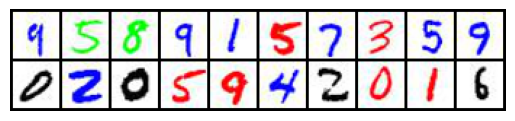

In [8]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks [30 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder [15 Points]**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, you are requested to implement the layers and the forward function of the model. You should flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [9]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super(MnistAutoencoderFC, self).__init__()

        # Encoder part
        self.encoder = nn.Sequential(
            #Layer 1
            nn.Linear(3 * 32 * 32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            #Layer 2
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),

            #Layer 3
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2)
        )

        # Decoder part
        self.decoder = nn.Sequential(
            #Layer 1
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),

            #Layer 2
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            #Layer 3
            nn.Linear(256, 3 * 32 * 32),
            nn.Tanh()
        )       

    def forward(self, x):
      # Flatten
      x = x.view(x.size(0), -1)

      # Encode
      latent = self.encoder(x)

      # Decode
      decode = self.decoder(latent)
      
      # Unflatten and return
      return decode.view(decode.size(0), 3, 32, 32) 

#### **Convolutional Autoencoder [15 Points]**

In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size should be set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [10]:
class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super(MnistAutoencoderConv, self).__init__()

        # Encoder part
        self.encoder = nn.Sequential(
            #Layer 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Layer 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Layer 3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder part
        self.decoder = nn.Sequential(
            #Layer 1
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            #Layer 2
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            #Layer 3
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        #Encode, Decode and return
        return self.decoder( self.encoder(x) )

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [11]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    # Output list
    losses = list() 
    
    # Take them to cuda
    model.to(device)
    loss_func.to(device)

    # batch count
    batch_count = len(train_dataloader)
    
    # For each epoch..
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        # For each batch
        for batch_len in range(0, batch_count ):
            #Get the next batch
            images = next(iter(train_dataloader))
            images = images.to(device) # cuda
            
            # Mask the input images
            masked_images = images.clone()
            masked_images[:, :, :, 16:32] = -1

            # Forward pass
            outputs = model(masked_images)
            
            # Calculate loss
            loss = loss_func(outputs, images)

            # Backward pass and optimization 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update epoch loss
            epoch_loss = epoch_loss + loss.item()
        
        # Meaned epoch loss 
        epoch_loss = epoch_loss / batch_count

        # Add to the output loss list
        losses.append(epoch_loss)
        
        # Print the epoch results
        print("Epoch: " + str(epoch) + "/" + str(num_epochs) + "\tLoss: " + str(epoch_loss))
    
    # returns the list of losses 
    return losses


### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [12]:
def evaluate_model(model, test_dataloader):
    # cuda
    model = model.to(device)
    model.eval()

    # MSE loss function
    mse = nn.MSELoss()
    
    loss = count = float(0)
    
    with torch.no_grad():
        for _, images in enumerate(test_dataloader):
            images = images.to(device)
            
            # Mask the input images
            masked_images = images.clone()
            masked_images[:, :, :, 16:32] = -1
            
            # Forward pass
            outputs = model(masked_images)
            # Calculate loss
            loss = loss + images.size(0) * mse(outputs, images).item()
            # Update count
            count = count + images.size(0)

    # Calculates mean loss and returns it
    return float(loss / count)

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

**Do not change the cell**

In [13]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:32] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model [5 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Epoch: 1/50	Loss: 0.14539293049241575
Epoch: 2/50	Loss: 0.08013201701214247
Epoch: 3/50	Loss: 0.0723306850322982
Epoch: 4/50	Loss: 0.06805050429290213
Epoch: 5/50	Loss: 0.0652716264719396
Epoch: 6/50	Loss: 0.0626198057409214
Epoch: 7/50	Loss: 0.06136523831226027
Epoch: 8/50	Loss: 0.0599513563334637
Epoch: 9/50	Loss: 0.05911042176358535
Epoch: 10/50	Loss: 0.05793276330089325
Epoch: 11/50	Loss: 0.057231431412498666
Epoch: 12/50	Loss: 0.056615141656278345
Epoch: 13/50	Loss: 0.05558124674803308
Epoch: 14/50	Loss: 0.055312650840338845
Epoch: 15/50	Loss: 0.05455776676059226
Epoch: 16/50	Loss: 0.05415454809851659
Epoch: 17/50	Loss: 0.053966997715327744
Epoch: 18/50	Loss: 0.053343081770612456
Epoch: 19/50	Loss: 0.052818449714299665
Epoch: 20/50	Loss: 0.05280642986983594
Epoch: 21/50	Loss: 0.052181596631932135
Epoch: 22/50	Loss: 0.05195890664768493
Epoch: 23/50	Loss: 0.05159001387274631
Epoch: 24/50	Loss: 0.05155459082092318
Epoch: 25/50	Loss: 0.05139420511167678
Epoch: 26/50	Loss: 0.0510584788

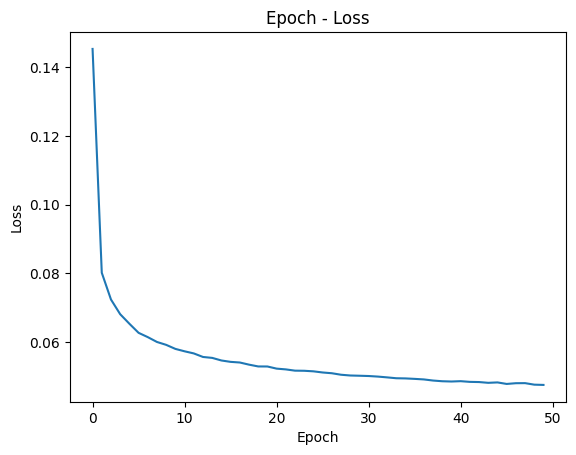

The accuracy the model (fully connected) reached on the test dataset: 0.04738330328464508


In [14]:
seed_everything(464)
model_fc = MnistAutoencoderFC() ## Uncomment when the model is implemented

# TODO 
# loss function as MSE
loss_function = nn.MSELoss()

# set learning rate to 2e-4
learning_rate = 2e-4

# create Adam optimizer
optimizer = optim.Adam(model_fc.parameters(), lr=learning_rate)

# set number of epochs to 50
epochs = 50

# Training the model
losses_fc = train_model(model_fc, train_dataloader, optimizer, loss_function, epochs)

# Visualize the returned losses on a plot (loss vs. epoch)
plt.plot(losses_fc)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch - Loss")
plt.show()

# Call evaluate_model function and print result
print( "The accuracy the model (fully connected) reached on the test dataset: " + str(evaluate_model(model_fc, test_dataloader)) )

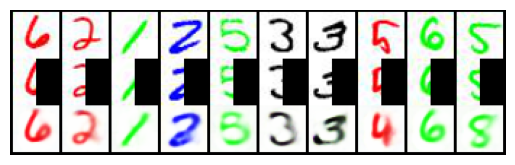

In [15]:
visualize_inpainting(model_fc, test_dataset) ## Uncomment when the model is trained

### **Training and Evaluating the Convolutional Model [5 Points]**

Apply the same steps given in the FC Autoencoder part.

Epoch: 1/50	Loss: 0.3040585517502197
Epoch: 2/50	Loss: 0.09024882567165148
Epoch: 3/50	Loss: 0.07379729425072518
Epoch: 4/50	Loss: 0.06826662023544616
Epoch: 5/50	Loss: 0.06521906904266465
Epoch: 6/50	Loss: 0.06293085528075543
Epoch: 7/50	Loss: 0.06120639778864201
Epoch: 8/50	Loss: 0.06027224280721391
Epoch: 9/50	Loss: 0.05908408710528213
Epoch: 10/50	Loss: 0.05813998241653985
Epoch: 11/50	Loss: 0.057429546199719926
Epoch: 12/50	Loss: 0.05657889308584163
Epoch: 13/50	Loss: 0.05609860934336167
Epoch: 14/50	Loss: 0.0556690834148232
Epoch: 15/50	Loss: 0.05506936021987587
Epoch: 16/50	Loss: 0.05486010545697968
Epoch: 17/50	Loss: 0.05464477922357714
Epoch: 18/50	Loss: 0.05391940609802066
Epoch: 19/50	Loss: 0.05359143448417144
Epoch: 20/50	Loss: 0.053659415930090354
Epoch: 21/50	Loss: 0.05305471606647877
Epoch: 22/50	Loss: 0.053187913964014226
Epoch: 23/50	Loss: 0.05301609467191007
Epoch: 24/50	Loss: 0.05253645691477582
Epoch: 25/50	Loss: 0.052564696144417423
Epoch: 26/50	Loss: 0.05213658457

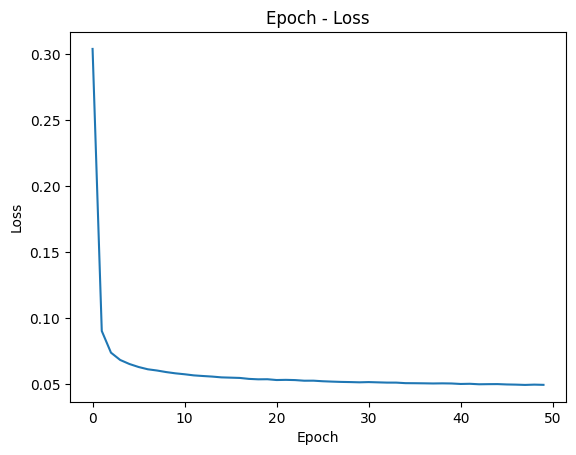

The accuracy the model (convolutional) reached on the test dataset: 0.05012447657585144


In [16]:
seed_everything(464)
model_conv = MnistAutoencoderConv() ## Uncomment when the model is implemented

# TODO
# Same steps with FC Autoencoder
optimizer = optim.Adam(model_conv.parameters(), lr=learning_rate)

# Training the model
losses_conv = train_model(model_conv, train_dataloader, optimizer, loss_function, epochs)

# Visualize the returned losses on a plot (loss vs. epoch)
plt.plot(losses_conv)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch - Loss")
plt.show()

# Call evaluate_model function and print result
print( "The accuracy the model (convolutional) reached on the test dataset: " + str(evaluate_model(model_conv, test_dataloader)) )

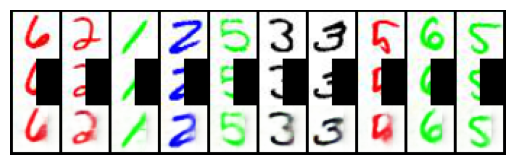

In [17]:
visualize_inpainting(model_conv, test_dataset) ## Uncomment when the model is trained

### **Discussion [10 Points]**

Discuss the results that you obtained after training the models. Compare the inpainting performances by the visualizations and the accuracy metrics. You can write your answer in the below cell.

---

**Actually Convolutional one would be expected to give better results in image completion because Convolutional models are more successful in image data than Fully Connected, but Fully Connected's accuracy rate was higher compared to Convolution in the results I got. This may be due to various factors such as the structure of the model, data set and hyperparameters.**

**If we compare the inpainted images (from left to right):**

* It is clear that the number 6 is clearer in Fully Connected.

* The number 2 is similar to each other.

* The number 1 consists of a straight line and Fully Connected is somewhat more similar to the original.

* In the lower right part of the number 2, both have blurs. Fully Connected has less blurs.

* The top of the number 5 is longer in Convolutional, which made it closer to the original.

* In the number 3 (left), both have blurs.

* We can say with certainty that 3 (right) both of them are successful.

* The number 5 was vey blurry in Convolutional, but it was predicted as 4 in Fully Connected.

* In the number 6, Fully Connected is better.

* The number 5 is very close to the real image in Fully Connected, only slightly lighter in color.

**Also if we look at the epoch vs loss graph provided below. Convolutional model has a much higher loss in the first epoch compared to Fully Connected, but as you can see in the graph, they get closer to each other as the number of epochs increases.**

---

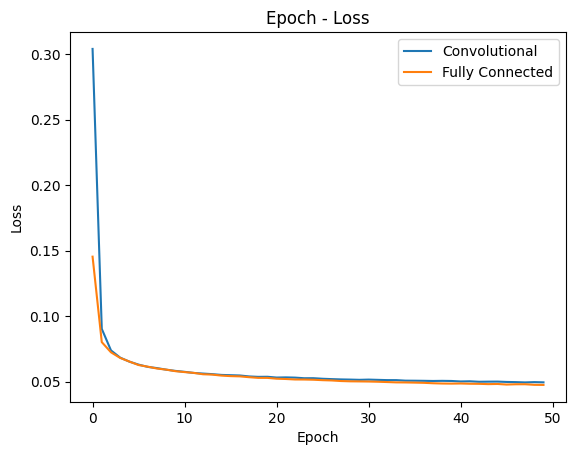

In [18]:
# Comparing the results of the two models.
plt.plot(losses_conv)
plt.plot(losses_fc)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch - Loss")
plt.legend(["Convolutional", "Fully Connected"])
plt.show()